In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm_notebook

from dwd import download_all_kl_files, read_dwd_kl_file, get_dwd_stations, BASE_URL

%matplotlib inline

In [2]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = f'{n}%'
    return percentile_

In [29]:
stations = get_dwd_stations()

stations['operation_time'] = stations['bis_datum'] - stations['von_datum']
stations = (
    stations
    .sort_values('von_datum', ascending=False)
    .sort_values('operation_time', ascending=True)
)
stations.head()
stations.tail(30)

,id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,operation_time
1015,5099,1907-05-01,2019-06-22,132,49.7326,6.6131,Trier-Zewen,Rheinland-Pfalz,40960 days
623,3015,1906-04-01,2019-06-22,98,52.2085,14.1180,Lindenberg,Brandenburg,41355 days
1135,5732,1887-07-01,2003-06-30,8,54.6928,8.5271,Wrixum/Föhr,Schleswig-Holstein,42367 days
664,3196,1902-01-01,2019-06-22,81,53.3223,11.9319,Marnitz,Mecklenburg-Vorpommern,42906 days
517,2486,1901-01-01,2019-06-22,271,49.4262,7.7557,Kaiserslautern,Rheinland-Pfalz,43271 days
1141,5792,1900-08-01,2019-06-22,964,47.4209,10.9847,Zugspitze,Bayern,43424 days
1,3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,43918 days
381,1757,1898-03-01,2019-06-22,2,54.0967,13.4056,Greifswald,Mecklenburg-Vorpommern,44307 days
107,445,1898-01-01,2019-06-22,84,51.8218,11.7109,Bernburg/Saale (Nord),Sachsen-Anhalt,44366 days
193,863,1890-01-01,2012-03-31,585,51.7904,10.3470,Clausthal-Zellerfeld,Niedersachsen,44649 days


In [4]:
download_all_kl_files()

100%|█████████▉| 1212/1213 [00:32<00:00, 27.60it/s]

In [31]:
from glob import glob

station_data = {}

for station in tqdm_notebook(stations.itertuples(), total=len(stations)):
    
    files = glob(f'data/kl/tageswerte_KL_{station.id:05d}_*')
    
    if not files:
        continue
        
    station_data[station.id] = pd.concat([read_dwd_kl_file(f) for f in files])

In [87]:
station_yearly = pd.DataFrame(index=np.arange(1750, 2020))


ids = stations.sort_values(['bis_datum', 'operation_time'], ascending=False).id

for station_id in tqdm_notebook(ids, total=len(station_data)):
    df = station_data.get(station_id)
    if df is None:
        continue
    by_year = df.groupby(df['MESS_DATUM'].dt.year)['TMK'].agg(
        ['count', 'mean']
    )
    by_year.index.name = 'Jahr'
    
    station_yearly[station_id] = by_year.loc[by_year['count'] > 350, 'mean']

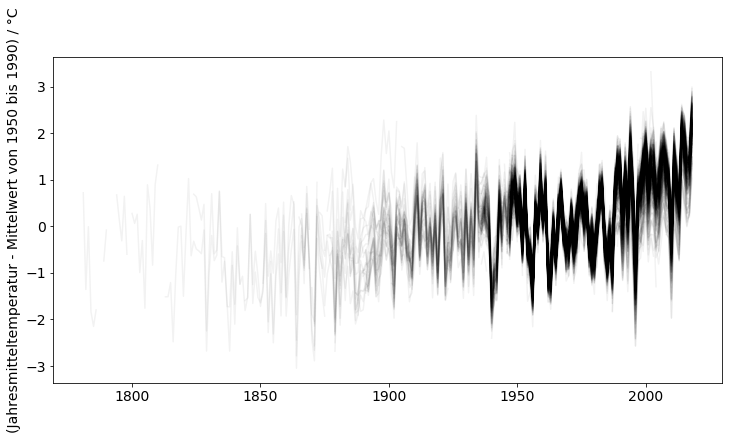

In [74]:
   
plt.figure(figsize=(12, 6))

for c in station_yearly.columns:
    plt.plot(station_yearly.index, station_yearly[c] - station_yearly[c].loc['1950':'1990'].mean(), color='k', alpha=0.05)

plt.ylabel('(Jahresmitteltemperatur - Mittelwert von 1950 bis 1990) / °C')
plt.xlabel('')
None

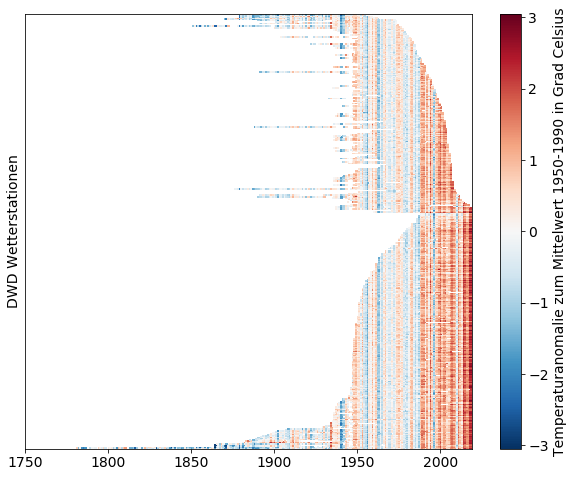

In [88]:
station_yearly.dropna(thresh=30, axis=1, inplace=True)


data = (station_yearly.values - station_yearly.loc['1950':'1990'].mean().values).T
limit = np.nanmax(np.abs(data))

plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 8))
plt.pcolormesh(
    station_yearly.index,
    np.arange(len(station_yearly.columns)),
    data,
    cmap='RdBu_r',
    vmin=-limit,
    vmax=limit,
)
plt.yticks([])
plt.ylabel('DWD Wetterstationen')
plt.colorbar(label='Temperaturanomalie zum Mittelwert 1950-1990 in Grad Celsius')